In [21]:
import os
import numpy as np
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize  
from sklearn.feature_extraction.text import CountVectorizer

import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt


from sklearn.datasets import fetch_20newsgroups
%matplotlib inline

### Užkrauname duomenų rinkinį
 Pasirenkame tik 9 kategorijas, pasirinktos kategorijos ir atitinkamų kategorijų dydžiai parodyti grafike žemiau

Kategorijos:
	comp.sys.mac.hardware
	comp.windows.x
	sci.space
	rec.autos
	rec.motorcycles
	rec.sport.baseball
	rec.sport.hockey
	soc.religion.christian
	talk.politics.guns

Iš viso 8824 dokumentų


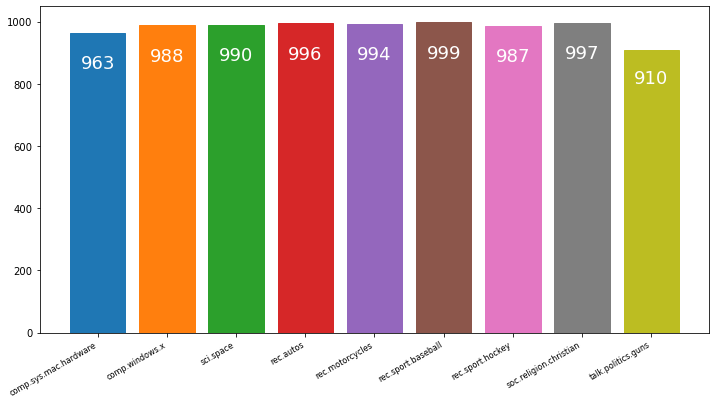

In [2]:
cats = ['comp.sys.mac.hardware', 'comp.windows.x', 'sci.space', 'rec.autos', 'rec.motorcycles',
        'rec.sport.baseball', 'rec.sport.hockey', 'soc.religion.christian', 'talk.politics.guns']
data = fetch_20newsgroups(subset='all', categories=cats)

print("Kategorijos:")
for cat in cats:
    print("\t{}".format(cat))

texts = data.data
label = data.target
print("\nIš viso {} dokumentų".format(len(texts)))

(unique, counts) = np.unique(label, return_counts=True)

fig, ax = plt.subplots(1,1,figsize=(12,6))


ax.bar(range(len(cats)), counts)
ax.set_xticks(range(len(cats)))
ax.set_xticklabels(cats, rotation=30, ha='right', fontsize=8)


for rect, c, value in zip(ax.patches, ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive'], counts):
    rect.set_color(c)
    height = rect.get_height()
    width = rect.get_width()
    x_loc = rect.get_x()
    ax.text(x_loc + width/2, 0.9*height, value, ha='center', va='center', fontsize=18, color='white')

##### Apžvelkime kokio ilgio mūsų tekstai

In [49]:
dokumentu_ilgiai = []
for text in texts:
    dokumentu_ilgiai.append(len(text.split(' ')))
    
print("Vidutinis tekstų ilgis: {} žodis".format(round(sum(dokumentu_ilgiai)/len(dokumentu_ilgiai))))
print("Trumpiausias tekstas: {} žodiai".format(min(dokumentu_ilgiai)))
print("Ilgiausias tekstas: {} žodiai".format(max(dokumentu_ilgiai)))

Vidutinis tekstų ilgis: 301 žodis
Trumpiausias tekstas: 9 žodiai
Ilgiausias tekstas: 20235 žodiai


Matome, kad yra labai trumpų dokumentų ir labai ilgų.. Tai galime matyti ir grafiškai, kad pagrine tekstai yra iki 500 žodžių

C:\Users\user2\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(-50.0, 2300.0)

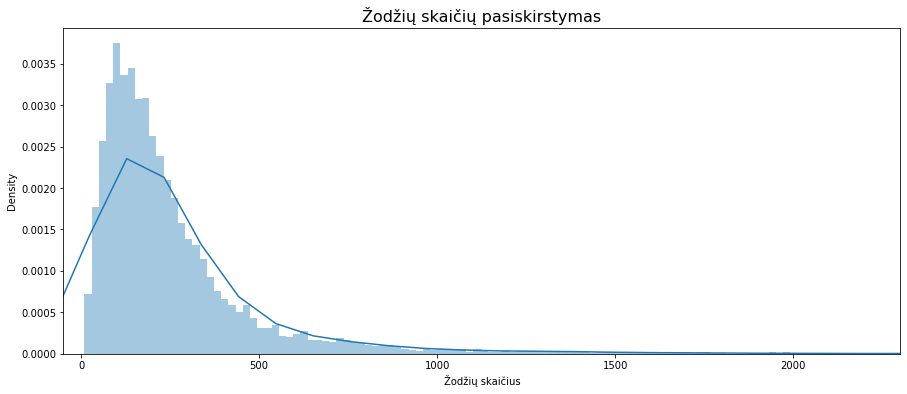

In [48]:
fig, ax = plt.subplots(figsize=(15,6))

ax.set_title("Žodžių skaičių pasiskirstymas", fontsize=16)
ax.set_xlabel("Žodžių skaičius")
sns.distplot(dokumentu_ilgiai, bins=1000, ax=ax);
plt.xlim(-50, 2300)

### Duomenų rinkinio paruošimas
* Paverčiam visą tekstą iš mažųjų raidžių
* Iš teksto pašaliname skaičius
* Pašaliname email'us
* Panaikiname simbolius, kurie nėra raidės: "[!”#$%&’()*+,-./:;<=>?@[\]^_`{|}~]"
* Pašaliname nereikšmingus žodžius ir žodžius kuriu ilgis yra trumpesnis nei 3 raidės

In [51]:
stop_words = stopwords.words('english')
stop_wrds = ''
for wrd in stop_words:
    stop_wrds += wrd + ' '
stop_words = stop_wrds.translate(str.maketrans('', '', string.punctuation))
stop_words = set(word_tokenize(stop_words))


preprocessed_texts = []
for text in texts:
    tmp = text.lower() # visos raides mazosios
    tmp = re.sub(r'\d+', '', tmp) # panaikinam skaicius
    tmp = ' '.join([w for w in tmp.split() if '@' not in w]) # panaikinam email'us
    tmp = tmp.translate(str.maketrans('', '', string.punctuation)) # panaikinti [!”#$%&’()*+,-./:;<=>?@[\]^_`{|}~]
    word_tokens = word_tokenize(tmp)
    tmp = [w for w in word_tokens if (not w in stop_words and len(w)>2)] # panaikinam nereiksmingus zodzius ir trumpesnius nei 2 raides
    
    preprocessed_texts.append(tmp)

### Sudarome žodyną

In [133]:
def word_dict(texts):
    zodynas = {}
    for text in texts:
        for word in text:
            try:
                zodynas[word].add(1)
            except:
                zodynas[word] = zodynas.get(word, 0) + 1
    
    mx_count = len(texts)//1.8
#    values = np.array(list(zodynas.values()))
#    dict_words = np.array(list(zodynas))
#   idx = np.where((values > 10) & (values < mx_count))
#   new_dict = dict_words[idx]
    
#    unwanted = set(zodynas) - set(new_dict)
#    for unwanted_key in unwanted: del zodynas[unwanted_key]
        
    return zodynas

zodynas = word_dict(preprocessed_texts)
print("Žodyną sudaro {} žodžiai".format(len(zodynas)))



Žodyną sudaro 69593 žodžiai


Grafike žemiau matome dažniausiai pasitaikančius žodžius mūsų tekstuose, remiantis šiuo grafiku galime iš žodynp išmesti žodžius pasitaikančius dažniau negu 2000 kartų

C:\Users\user2\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Dažniausiai pasitaikantys žodžiai')

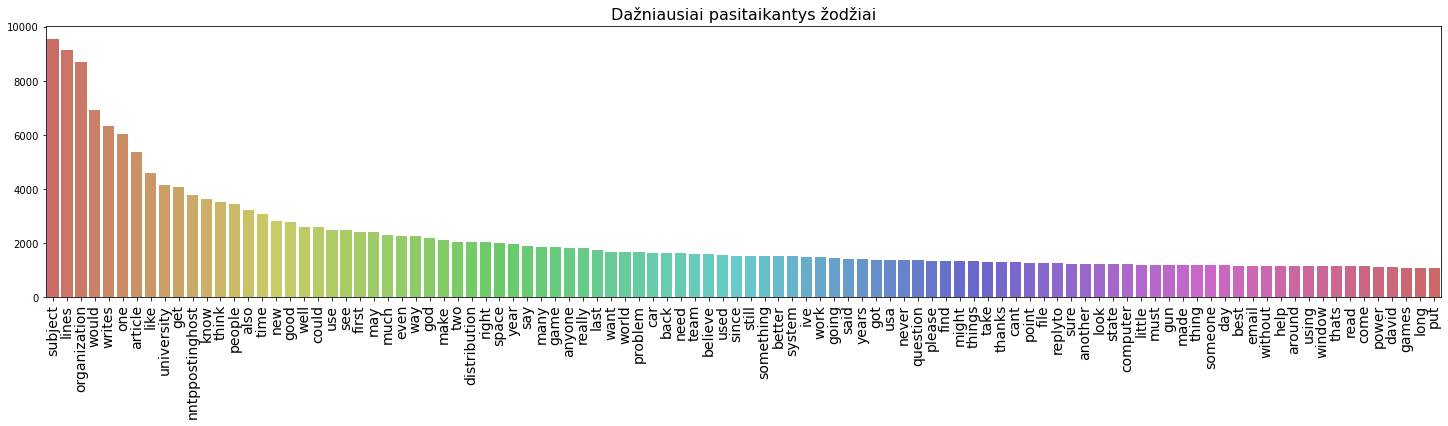

In [134]:
zodis, daznis = zip(*sorted(zodynas.items(), key=lambda kv: kv[1]))


fig, ax = plt.subplots(1,1,figsize=(25,5))
sns.barplot(list(range(100)), np.array(daznis[-100:][::-1]), palette='hls', ax=ax)
ax.set_xticks(list(range(100)))
ax.set_xticklabels(zodis[-100:][::-1], fontsize=14, rotation=90)
ax.set_title("Dažniausiai pasitaikantys žodžiai", fontsize=16)


Išmetame labai dažnus ir labai retus žodžius, nes tai gali būti labai unikalūs žodžiai arba tiesiog gramatinės klaidos

In [135]:
x = np.array(list(zodynas.values()))
dict_words = np.array(list(zodynas))
mx_count = 2000
idx = np.where((x > 10) & (x < mx_count))
new_dict = dict_words[idx]
    
unwanted = set(zodynas) - set(new_dict)
for unwanted_key in unwanted: del zodynas[unwanted_key]
    
print("Po labai dažnų ir labai retų žodžių pašalinimo žodyne liko {} žodžiai".format(len(zodynas)))


Po labai dažnų ir labai retų žodžių pašalinimo žodyne liko 11462 žodžiai


In [136]:
zodynas

{'adam': 93,
 'samuel': 71,
 'want': 1685,
 'macweek': 40,
 'dsg': 31,
 'stanford': 123,
 'usa': 1390,
 'subscription': 32,
 'seem': 660,
 'able': 703,
 'find': 1331,
 'card': 471,
 'anywhere': 124,
 'email': 1169,
 'uniforms': 44,
 'world': 1674,
 'enjoy': 105,
 'trend': 34,
 'towards': 146,
 'classic': 81,
 'style': 127,
 'uniform': 38,
 'disagree': 130,
 'person': 649,
 'wants': 282,
 'return': 344,
 'road': 452,
 'remembered': 16,
 'reason': 835,
 'especially': 448,
 'hats': 12,
 'green': 259,
 'caps': 141,
 'cardinal': 46,
 'navy': 24,
 'blue': 312,
 'cap': 44,
 'marketing': 102,
 'money': 566,
 'made': 1198,
 'sales': 124,
 'merchandise': 11,
 'jeffrey': 38,
 'carter': 66,
 'page': 161,
 'accepting': 75,
 'jeesus': 29,
 'heart': 226,
 'pennsylvania': 76,
 'eric': 301,
 'molas': 14,
 'firstly': 13,
 'atheist': 88,
 'drivel': 15,
 'deleted': 296,
 'seed': 31,
 'miraculous': 11,
 'thing': 1187,
 'sit': 71,
 'shelf': 24,
 'forever': 126,
 'knows': 262,
 'stuck': 107,
 'ground': 238,


### Bag of Words

In [146]:
vectorizer_bow = CountVectorizer(min_df = 10, dtype=np.uint8)
bow = vectorizer_bow.fit_transform(preprocessed_texts)
bow.shape

(8824, 10290)

### Tf-idf

In [149]:
vectorizer_tfidf = TfidfVectorizer(min_df = 10)
tfidf = vectorizer_tfidf.fit_transform(preprocessed_texts)
tfidf.shape

(8824, 10290)

In [35]:
inertia = []
sil = []# changing the number of clusters 
for k in range(2,15):
    
    km = KMeans(n_clusters=k, random_state=144)
    km.fit(X)
    y_pred = km.predict(X)
    
    inertia.append((k, km.inertia_))
    sil.append((k, silhouette_score(X, y_pred)))

Text(0.5, 1.0, 'Silhouetter Score Curve')

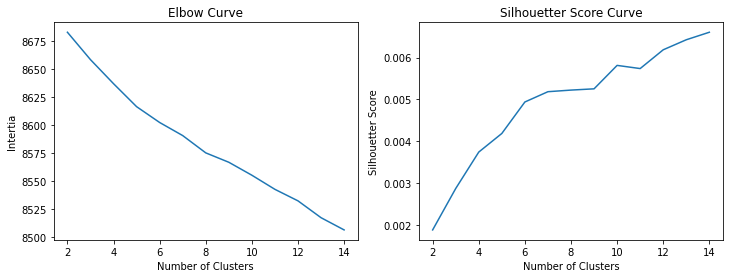

In [36]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

# Plotting Elbow Curve
x_iner = [x[0] for x in inertia]
y_iner  = [x[1] for x in inertia]
ax[0].plot(x_iner, y_iner)
ax[0].set_xlabel('Number of Clusters')
ax[0].set_ylabel('Intertia')

# Plotting Silhouetter Score
ax[0].set_title('Elbow Curve')
x_sil = [x[0] for x in sil]
y_sil  = [x[1] for x in sil]
ax[1].plot(x_sil, y_sil)
ax[1].set_xlabel('Number of Clusters')
ax[1].set_ylabel('Silhouetter Score')
ax[1].set_title('Silhouetter Score Curve')

In [26]:
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

In [27]:
for i in range(9):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])

Cluster 0:
 bike
 com
 dod
 edu
 ca
 writes
 article
 ride
 sun
 bmw
Cluster 1:
 god
 jesus
 christians
 sin
 church
 christ
 christian
 bible
 people
 edu
Cluster 2:
 game
 hockey
 ca
 team
 edu
 nhl
 espn
 games
 play
 buffalo
Cluster 3:
 com
 car
 subject
 lines
 organization
 edu
 gun
 window
 like
 don
Cluster 4:
 nasa
 gov
 space
 jpl
 jsc
 gsfc
 shuttle
 baalke
 higgins
 kelvin
Cluster 5:
 edu
 university
 subject
 lines
 organization
 posting
 article
 host
 nntp
 writes
Cluster 6:
 edu
 baseball
 game
 team
 year
 games
 players
 com
 braves
 hit
Cluster 7:
 mac
 apple
 edu
 monitor
 drive
 centris
 quadra
 lc
 scsi
 card
Cluster 8:
 henry
 access
 digex
 alaska
 toronto
 pat
 zoo
 space
 spencer
 edu


In [32]:
X

<8824x83299 sparse matrix of type '<class 'numpy.float64'>'
	with 958626 stored elements in Compressed Sparse Row format>